In [ ]:
from google.colab import drive
import pickle

## Data import

In [ ]:
# Link Google Drive account and download dataset
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Percorso dei file pickle nel Drive
train_path = '/content/gdrive/My Drive/TM_DFs/train_data.pkl'
val_path = '/content/gdrive/My Drive/TM_DFs/val_data.pkl'
test_path = '/content/gdrive/My Drive/TM_DFs/test_data.pkl'

In [ ]:
import pandas as pd

# Carica i DataFrame dai file pickle
train_df = pd.read_pickle(train_path)
val_df = pd.read_pickle(val_path)
test_df = pd.read_pickle(test_path)

# Verifica il caricamento
print("Train DataFrame:")
print(train_df.head())
print("\nValidation DataFrame:")
print(val_df.head())
print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame:
    emo_label senti_label                                           original  \
0  excitement     bullish       $AMZN Dow futures up by 100 points already 🥳   
1  excitement     bullish  $TSLA Daddy's drinkin' eArly tonight! Here's t...   
2   confusion     bullish  $AAPL We’ll been riding since last December fr...   
3  excitement     bullish            $TSLA happy new year, 2020, everyone🍷🎉🙏   
4  excitement     bullish  $TSLA haha just a collection of greats..."Mars...   

                                           processed  \
0  Amazon Dow futures up by 100 points already  [...   
1  Tesla Daddy's drinkin' eArly tonight! Here's t...   
2  Apple We’ll been riding since last December fr...   
3  Tesla happy new year, 2020, everyone [wine gla...   
4  Tesla haha just a collection of greats..."Mars...   

                                                bert  \
0      Amazon Dow futures up by 100 points already 🥳   
1  Tesla Daddy's drinkin' eArly tonight! Here's t... 

## Embeddings generation

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 21.8 MB/s eta 0:00:00


### Bertweet Embeddings

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import os

if torch.cuda.is_available():
    print("GPU disponibile:", torch.cuda.get_device_name(0))
else:
    raise RuntimeError("GPU non disponibile! Controlla la configurazione.")

output_folder = '/content/gdrive/My Drive/TM_DFs/bertweet_embeddings'
os.makedirs(output_folder, exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base").cuda()

def get_bertweet_embedding(text):

    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    inputs = {key: val.cuda() for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.squeeze().cpu().numpy()

def calculate_embeddings(df, text_column):
    embeddings = []
    for idx, text in enumerate(df[text_column]):
        if idx % 100 == 0:
            print(f"Processati {idx}/{len(df)} testi...")
        embeddings.append(get_bertweet_embedding(text))
    return np.array(embeddings)

print("Calcolando embeddings per il train set...")
train_embeddings = calculate_embeddings(train_df, 'bert')

print("Calcolando embeddings per il validation set...")
val_embeddings = calculate_embeddings(val_df, 'bert')

print("Calcolando embeddings per il test set...")
test_embeddings = calculate_embeddings(test_df, 'bert')

np.save(os.path.join(output_folder, "train_embeddings.npy"), train_embeddings)
np.save(os.path.join(output_folder, "val_embeddings.npy"), val_embeddings)
np.save(os.path.join(output_folder, "test_embeddings.npy"), test_embeddings)

print(f"Embeddings salvati nella cartella: {output_folder}")

GPU disponibile: Tesla T4


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Calcolando embeddings per il train set...
Processati 0/8000 testi...
Processati 100/8000 testi...
Processati 200/8000 testi...
Processati 300/8000 testi...
Processati 400/8000 testi...
Processati 500/8000 testi...
Processati 600/8000 testi...
Processati 700/8000 testi...
Processati 800/8000 testi...
Processati 900/8000 testi...
Processati 1000/8000 testi...
Processati 1100/8000 testi...
Processati 1200/8000 testi...
Processati 1300/8000 testi...
Processati 1400/8000 testi...
Processati 1500/8000 testi...
Processati 1600/8000 testi...
Processati 1700/8000 testi...
Processati 1800/8000 testi...
Processati 1900/8000 testi...
Processati 2000/8000 testi...
Processati 2100/8000 testi...
Processati 2200/8000 testi...
Processati 2300/8000 testi...
Processati 2400/8000 testi...
Processati 2500/8000 testi...
Processati 2600/8000 testi...
Processati 2700/8000 testi...
Processati 2800/8000 testi...
Processati 2900/8000 testi...
Processati 3000/8000 testi...
Processati 3100/8000 testi...
Processati

### Distil-RoBERTa embeddings

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import os

tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
model = AutoModel.from_pretrained("j-hartmann/emotion-english-distilroberta-base").cuda()

def get_embeddings(text):

    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: val.cuda() for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state.mean(dim=1)

    return embeddings.squeeze().cpu().numpy()

def calculate_embeddings(df, text_column):
    embeddings = []
    for idx, text in enumerate(df[text_column]):
        if idx % 100 == 0:
            print(f"Processati {idx}/{len(df)} testi...")
        embeddings.append(get_embeddings(text))
    return np.array(embeddings)

print("Calcolando embeddings per il train set...")
X_train_embeddings = calculate_embeddings(train_df, 'bert')

print("Calcolando embeddings per il validation set...")
X_val_embeddings = calculate_embeddings(val_df, 'bert')

print("Calcolando embeddings per il test set...")
X_test_embeddings = calculate_embeddings(test_df, 'bert')

output_folder = '/content/gdrive/My Drive/TM_DFs/roberta_embeddings'
os.makedirs(output_folder, exist_ok=True)

np.save(os.path.join(output_folder, "train_embeddings.npy"), X_train_embeddings)
np.save(os.path.join(output_folder, "val_embeddings.npy"), X_val_embeddings)
np.save(os.path.join(output_folder, "test_embeddings.npy"), X_test_embeddings)

print(f"Embeddings salvati nella cartella: {output_folder}")

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calcolando embeddings per il train set...
Processati 0/8000 testi...
Processati 100/8000 testi...
Processati 200/8000 testi...
Processati 300/8000 testi...
Processati 400/8000 testi...
Processati 500/8000 testi...
Processati 600/8000 testi...
Processati 700/8000 testi...
Processati 800/8000 testi...
Processati 900/8000 testi...
Processati 1000/8000 testi...
Processati 1100/8000 testi...
Processati 1200/8000 testi...
Processati 1300/8000 testi...
Processati 1400/8000 testi...
Processati 1500/8000 testi...
Processati 1600/8000 testi...
Processati 1700/8000 testi...
Processati 1800/8000 testi...
Processati 1900/8000 testi...
Processati 2000/8000 testi...
Processati 2100/8000 testi...
Processati 2200/8000 testi...
Processati 2300/8000 testi...
Processati 2400/8000 testi...
Processati 2500/8000 testi...
Processati 2600/8000 testi...
Processati 2700/8000 testi...
Processati 2800/8000 testi...
Processati 2900/8000 testi...
Processati 3000/8000 testi...
Processati 3100/8000 testi...
Processati

## BERT-based Classifier

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### Distil-RoBERTa based Classifier

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
model = AutoModelForSequenceClassification.from_pretrained(
    "j-hartmann/emotion-english-distilroberta-base",
    num_labels=12,
    ignore_mismatched_sizes=True
).to(device)

emotion_mapping = {
    'ambiguous' : 0,
    'amusement': 1,
    'anger': 2,
    'anxiety': 3,
    'belief': 4,
    'confusion': 5,
    'depression': 6,
    'disgust': 7,
    'excitement': 8,
    'optimism': 9,
    'panic': 10,
    'surprise': 11
}

train_df['labels'] = train_df['emo_label'].map(emotion_mapping)
val_df['labels'] = val_df['emo_label'].map(emotion_mapping)
test_df['labels'] = test_df['emo_label'].map(emotion_mapping)

train_dataset = Dataset.from_pandas(train_df[['bert', 'labels']].rename(columns={'bert': 'text'}))
val_dataset = Dataset.from_pandas(val_df[['bert', 'labels']].rename(columns={'bert': 'text'}))
test_dataset = Dataset.from_pandas(test_df[['bert', 'labels']].rename(columns={'bert': 'text'}))

def tokenize_function(examples):
    tokens = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)
    tokens["labels"] = examples["labels"]
    return tokens

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.with_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset = val_dataset.with_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset = test_dataset.with_format("torch", columns=["input_ids", "attention_mask", "labels"])

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("Inizio dell'addestramento...")
trainer.train()

print("Valutazione sul test set...")
results = trainer.evaluate(test_dataset)
print(results)

Usando dispositivo: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Inizio dell'addestramento...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.880500,1.911529
2,1.806600,1.803676
3,1.707100,1.798943


Valutazione sul test set...


{'eval_loss': 1.7607983350753784, 'eval_runtime': 0.8215, 'eval_samples_per_second': 1217.318, 'eval_steps_per_second': 19.477, 'epoch': 3.0}


Classification report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array(test_dataset["labels"])

reverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[reverse_emotion_mapping[i] for i in range(12)]))

Classification Report:
              precision    recall  f1-score   support

   ambiguous       0.32      0.07      0.11        87
   amusement       0.27      0.33      0.29        83
       anger       0.52      0.29      0.37        38
     anxiety       0.41      0.41      0.41       134
      belief       0.36      0.18      0.24        89
   confusion       0.47      0.58      0.52        60
  depression       0.36      0.26      0.30        19
     disgust       0.36      0.57      0.44       121
  excitement       0.44      0.58      0.50       146
    optimism       0.40      0.44      0.42       163
       panic       0.50      0.19      0.28        31
    surprise       0.50      0.28      0.36        29

    accuracy                           0.39      1000
   macro avg       0.41      0.35      0.35      1000
weighted avg       0.39      0.39      0.38      1000



Confusion matrix

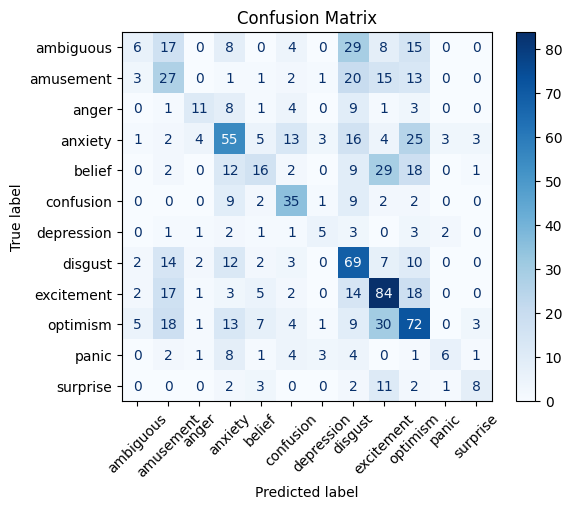

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)
logits, labels = predictions.predictions, predictions.label_ids

y_test_pred = np.argmax(logits, axis=1)
cm = confusion_matrix(labels, y_test_pred)
emotion_labels = list(emotion_mapping.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()